# Imports

In [1]:
import matplotlib.pyplot as plt

from scripts import FullEcosystem
import scripts.model_io as mio
import scripts.model_transform as mt

ModuleNotFoundError: No module named 'diatom'

# Toy example

The following example considers the computation of the abundance-growth space for a community comprised by two organisms (org1, org2) which reactions are displayed in the following figure:

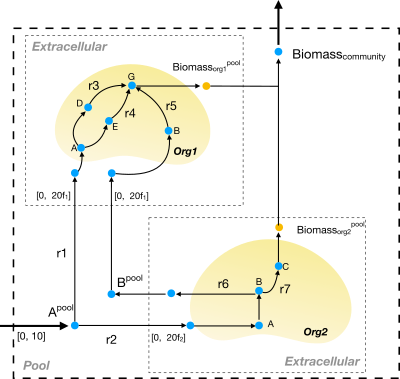

The example will start with construction of the models:

In [ ]:
from cobra import Model, Reaction, Metabolite

# ============================= Organism 1 =============================


model1 = Model('org1')

reactions: dict[str, dict] = {
    'Atr':     {'equation': 'A_e -> A_c'},
    'EX_A':    {'equation': 'A_e -> ', 'lowerbound': -1000},
    'Btr':     {'equation': 'B_e -> B_c'},
    'EX_B':    {'equation': 'B_e -> '},
    'AE':      {'equation': 'A_c -> E_c'},
    'AD':      {'equation': 'A_c -> D_c'},
    'DG':      {'equation': 'D_c -> 4 G_c'},
    'EG':      {'equation': 'E_c -> 2 G_c'},
    'BG':      {'equation': 'B_c -> 10 G_c'},
    'Gbio':    {'equation': 'G_c -> biom1_c'},
    'biomass': {'equation': 'biom1_c ->'},
}


mt.add_reactions_from_dictionary(model1, reactions)


model1.objective = 'biomass'


for metabolite in model1.metabolites:
    metabolite.compartment = metabolite.id[-1]
    

# ============================= Organism 2 =============================


model2 = Model('org2')


reactions: dict[str, dict] = {
    'Atr':     {'equation': 'A_e -> A_c'},
    'EX_A':    {'equation': 'A_e -> ', 'lowerbound': -1000},

    'EX_B':    {'equation': 'B_e -> '},

    'AB':      {'equation': 'A_c -> B_c'},
    'Btr':     {'equation': 'B_c -> B_e'},
    'BC':      {'equation': 'B_c -> 10 C_c'},

    'Cbio':    {'equation': 'C_c -> biom2_c'},
    'biomass': {'equation': 'biom2_c -> '},
}


mt.add_reactions_from_dictionary(model2, reactions)


model2.objective = 'biomass'


for metabolite in model2.metabolites:
    metabolite.compartment = metabolite.id[-1]


# save organisms
mio.save_models({'org1': model1, 'org2': model2})

unknown metabolite 'A_e' created
unknown metabolite 'A_c' created
unknown metabolite 'B_e' created
unknown metabolite 'B_c' created
unknown metabolite 'E_c' created
unknown metabolite 'D_c' created
unknown metabolite 'G_c' created
unknown metabolite 'biom1_c' created
unknown metabolite 'A_e' created
unknown metabolite 'A_c' created
unknown metabolite 'B_e' created
unknown metabolite 'B_c' created
unknown metabolite 'C_c' created
unknown metabolite 'biom2_c' created
model org1 stored
model org2 stored


Generation of the Ecosystem object which adds required exchanges and forms a community model:

In [ ]:
toy_model = FullEcosystem(member_models = [model1, model2], member_model_ids = ['org1','org2'], 
                          community_name = 'toy-example', community_id = 'org1-org2', solver='gurobi')



0. Copying member models ...
Read LP format model from file /tmp/tmp40u7vanq.lp
Reading time = 0.00 seconds
: 8 rows, 22 columns, 38 nonzeros
Read LP format model from file /tmp/tmp1mqjucki.lp
Reading time = 0.00 seconds
: 6 rows, 16 columns, 26 nonzeros

1. Storing exchanged metabolites information ...

2. Updating member model objects ids ...

3. Storing member objectives ...

4. Merging member models ...
Read LP format model from file /tmp/tmp80cqumng.lp
Reading time = 0.00 seconds
: 8 rows, 22 columns, 38 nonzeros
Read LP format model from file /tmp/tmpruqnx4ct.lp
Reading time = 0.00 seconds
: 6 rows, 16 columns, 26 nonzeros

5. Creating pool compartment, metabolites and reactions ...
{'A_e': {'org1': {'m_id': 'org1_A_e', 'name': '', 'formula': None, 'charge': None, 'ex_id': 'org1_EX_A', 'bounds': (-1000, 1000.0)}, 'org2': {'m_id': 'org2_A_e', 'name': '', 'formula': None, 'charge': None, 'ex_id': 'org2_EX_A', 'bounds': (-1000, 1000.0)}}, 'B_e': {'org1': {'m_id': 'org1_B_e', 'name'

The constructed community model has the sum of production of biomass as an objective for an estimation of maximum growth rate (relaxed problem)

In [ ]:
toy_model.community_model.objective.expression

1.0*org1_biomass - 1.0*org1_biomass_reverse_cc7c4 + 1.0*org2_biomass - 1.0*org2_biomass_reverse_facfe

Conditions of the simulation can be set up using the function 'set_pool_bounds'. A parameter "bioCons" can be added which represents biological constrains of input by the organisms of the community. If not specified, entry fluxes for each member of the community are maintained as it were originally.

In [ ]:
#Condiciones de simulacion
toy_model.community.set_pool_bounds({'A_e':(-10,1000)}, bioCons=-20) #name_scenario = 'test'
toy_model.community.set_pool_bounds({'B_e':(0,1000)}, bioCons=-20)

The function set_cluster_reactions, is called to determine which set of reactions are going to be considered for analysis. If Flux Coupling Analysis (FCA) results are provided the model is reduced in based of them to perform calculations:

In [ ]:
toy_model.analyze.select_reactions_for_fva()

Missing FCA results for: {'org1', 'org2'}.
Using non-blocked reactions only.
Total reactions considered for fva and clustering: 23


Construction of the grid is based on maximization of a relaxed problem of the community growth, without considering the effect of abundances and additional constraints such as ATPM. The parameter numPoints defines the density of points on each axis of the grid. We advice to use smaller numbers when exploring a new model and add them gradually sinces this can increase execution times.

In [ ]:
toy_model.grid.build_grid(numPoints = 10, drop_zero=True, relax_constraints=True)

Maximum community: 100.0
points shape: (100, 2)


In [ ]:
toy_model.community.set_member_reactions()
toy_model.grid.set_member_fractions()

Analyze_grid performs different analysis on the grid, particularly it can detect which points of the grid are feasible as follows. The parameter update_bounds refers to the updating of the exchange fluxes for different members of the community, as defined in Chan et al., (2017)

In [ ]:
toy_model.analyze.analyze_grid(analysis = 'feasibility', update_bounds=True)

100%|██████████| 99/99 [00:00<00:00, 406.13it/s]

grid feasible points: 82/99


Qualitative Flux Balance Analysis (FVA) can be performed on the grid, a modification of the rxn2Cluster parameter can be performed to only include Exchange reactions, as follows.

In [ ]:
oldRxn2Cluster = toy_model.analyze.fva_reactions
newRxn2Cluster = [r for r in oldRxn2Cluster if 'EX_' in r] # all exchanges
toy_model.analyze.fva_reactions = newRxn2Cluster

toy_model.analyze.analyze_grid(analysis = 'qual_fva', update_bounds=True)

Running qualitative fva over grid feasible points...


100%|██████████| 82/82 [00:12<00:00,  6.33it/s]


In [ ]:
toy_model.analyze.qual_vector_df.head(1000)

,EX_A_e,EX_B_e,EX_biom1_c,EX_biom2_c,org1_EX_A,org1_EX_B,org2_EX_A,org2_EX_B
0,-1.0,1.0,0.0,0.0,0.0,0.0,-1.0,1.0
1,-1.0,1.0,0.0,0.0,0.0,0.0,-1.0,1.0
2,-1.0,1.0,0.0,0.0,0.0,0.0,-1.0,1.0
3,-1.0,1.0,0.0,0.0,0.0,0.0,-1.0,1.0
4,-1.0,1.0,0.0,0.0,0.0,0.0,-1.0,1.0
...,...,...,...,...,...,...,...,...
89,-3.0,0.0,0.0,2.0,0.0,0.0,-3.0,0.0
90,-3.0,0.0,2.0,2.0,0.0,-3.0,-3.0,2.0
91,-3.0,0.0,2.0,2.0,0.0,-3.0,-3.0,2.0
92,-3.0,0.0,2.0,2.0,0.0,-3.0,-3.0,2.0


# Grid analysis

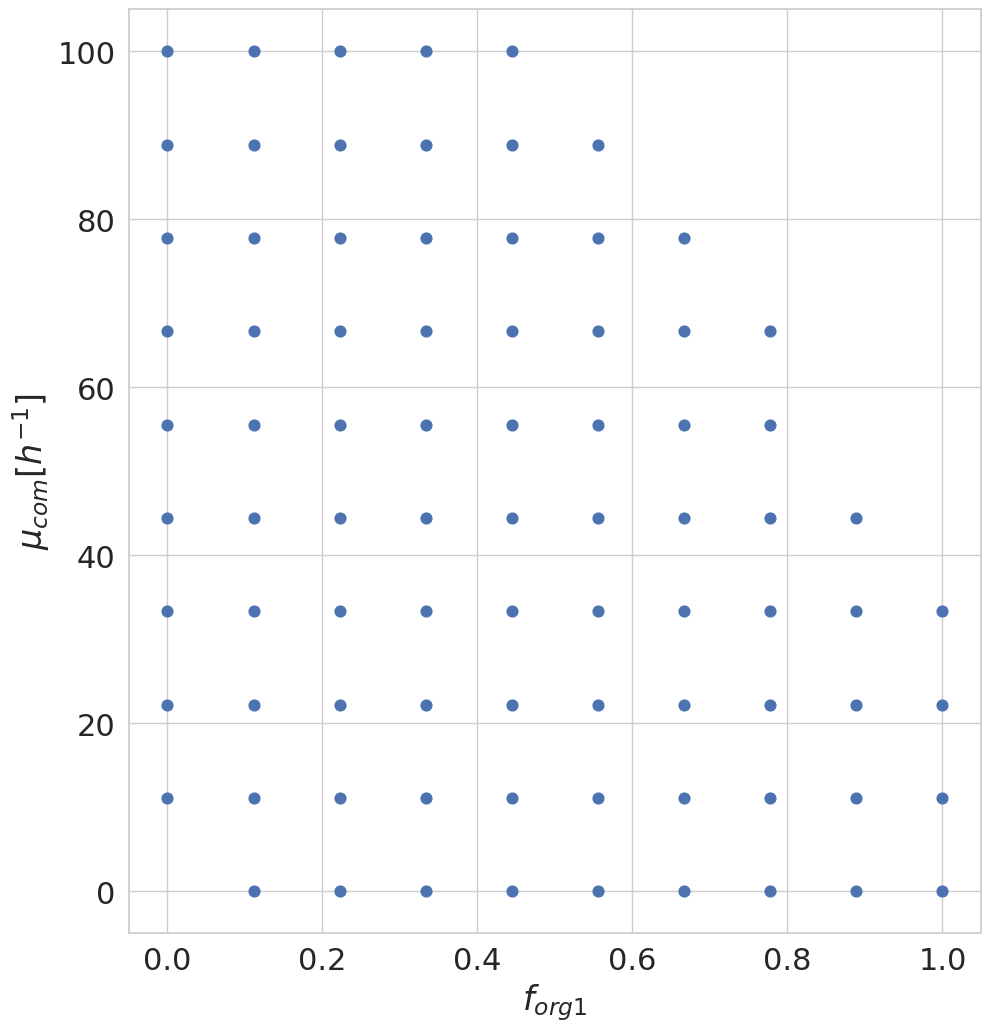

In [ ]:
plt.rcParams.update({'font.size': 30})

toy_model.plot.plot_2D_slice(model_ids=[], fixed_values=[], parent_cmap='tab20',s=60, figsize=(11,12), 
                         to_plot = None, show_edge=False,frac_prefix= None,
                            xlabel = '$f_{org1}$',
                            ylabel ='$\mu_{com}[h^{-1}]$', saveFile = 'grid')#, fractions=[0.6,0.4],  )

## Clustering

Parameters for function **clusterPoints**:
- **method**: method used for clustering. Default: *hierarchical* clustering with Jaccard distance.
- **numeric_delta**: difference between flux values accepted as zero(default: 1e-4).
- **k**: number of clusters to be obbtained (default: 20).

debug
[[-1.  1.  0.  0.  0.  0. -1.  1.]
 [-1.  1.  0.  0.  0.  0. -1.  1.]
 [-1.  1.  0.  0.  0.  0. -1.  1.]
 [-1.  1.  0.  0.  0.  0. -1.  1.]
 [-1.  1.  0.  0.  0.  0. -1.  1.]
 [-1.  1.  0.  0.  0.  0. -1.  1.]
 [-1.  1.  0.  0.  0.  0. -1.  1.]
 [-1.  1.  0.  0.  0.  0. -1.  1.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.]
 [-2.  1.  0.  2.  0.  0. -2.  1.]
 [-2.  1.  2.  2. -1. -1. -2.  1.]
 [-2.  1.  2.  2. -1. -1. -2.  1.]
 [-2.  1.  2.  2. -1. -1. -2.  1.]
 [-2.  1.  2.  2. -1. -1. -2.  1.]
 [-2.  1.  2.  2. -1. -1. -2.  1.]
 [-2.  1.  2.  2. -1. -1. -2.  1.]
 [-2.  1.  2.  2. -1. -1. -2.  1.]
 [-2.  1.  2.  2. -1. -1. -2.  1.]
 [-2.  0.  2.  0. -2.  0.  0.  0.]
 [-2.  1.  0.  2.  0.  0. -2.  1.]
 [-2.  1.  2.  2. -1. -1. -2.  1.]
 [-2.  1.  2.  2. -1. -1. -2.  1.]
 [-2.  1.  2.  2. -1. -1. -2.  1.]
 [-2.  1.  2.  2. -1. -1. -2.  1.]
 [-2.  1.  2.  2. -1. -1. -2.  1.]
 [-2.  1.  2.  2. -1. -1. -2.  1.]
 [-2.  1.  2.  2. -1. -1. -2.  1.]
 [-2.  1.  2.  2. -1. -1. -2.  1.]
 [-2.  0.  2. 

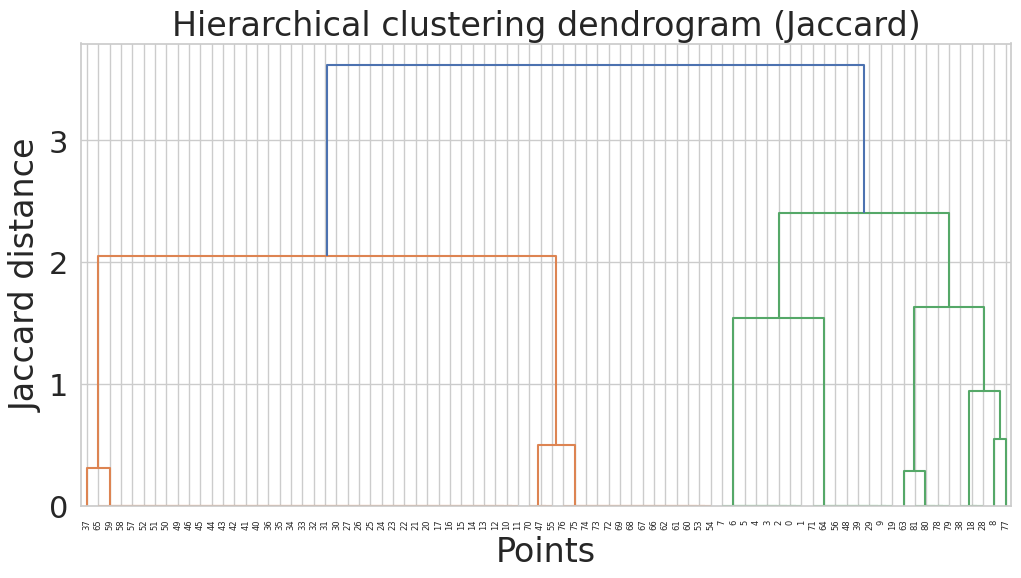

Done! n_clusters: 8, clusters: [3 3 3 3 3 3 3 3 7 4 1 1 1 1 1 1 1 1 6 4 1 1 1 1 1 1 1 1 6 4 1 1 1 1 1 1 1
 1 6 4 1 1 1 1 1 1 1 2 4 1 1 1 1 2 2 2 4 1 1 1 2 2 2 5 4 1 2 2 2 2 2 4 2 2
 2 2 2 8 5 5 5 5]


In [ ]:
toy_model.clustering.set_grid_clusters('hierarchical', k = 8, 
                                       lmethod = 'ward', criterion = 'maxclust')

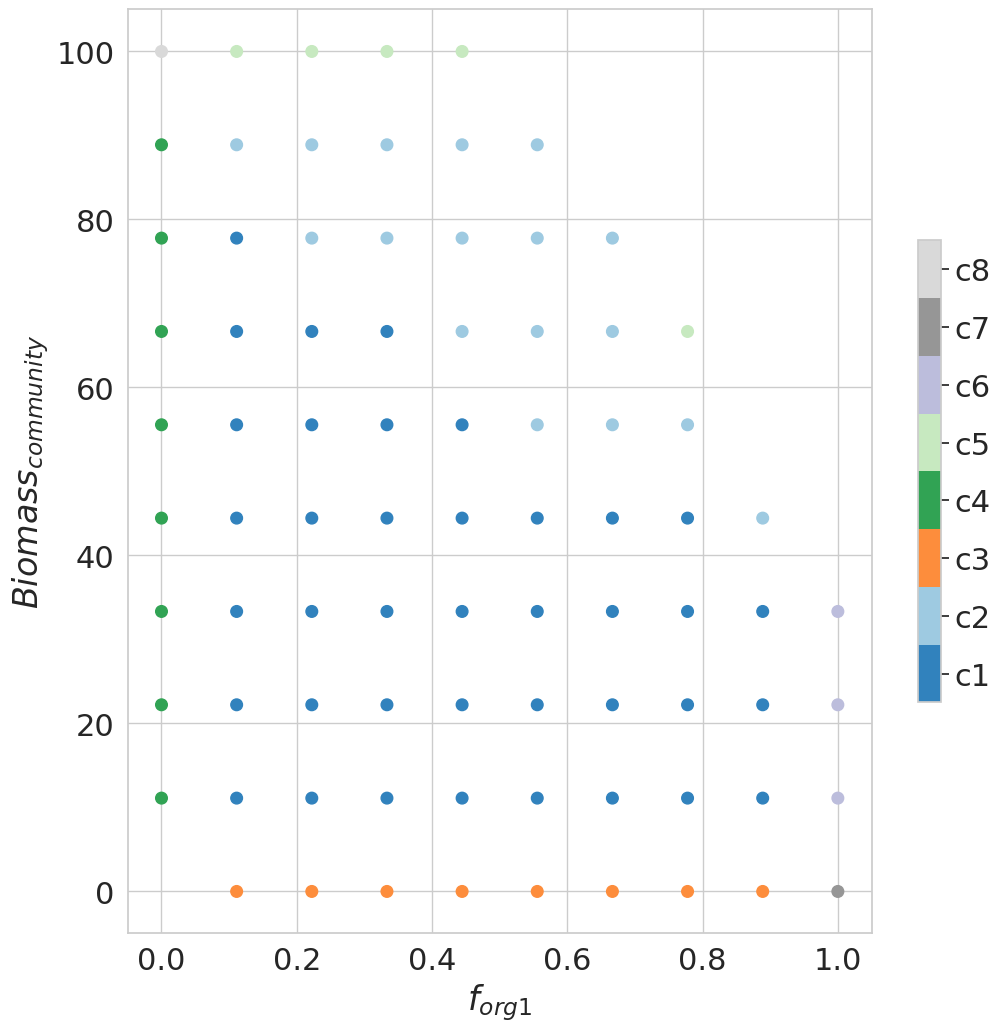

In [ ]:
toy_model.plot.plot_2D_slice(model_ids=[], fixed_values=[], parent_cmap='tab20c',s=70, figsize=(12,12), 
                         to_plot = 'cluster', show_edge=False,frac_prefix= None,
                            xlabel = '$f_{org1}$',
                            ylabel ='$Biomass_{community}$', saveFile='clusters_toy')



Qualitative changes in this system are associated with increased biomass production and changes in community composition. For instance structural plasticity (-0) of organism 1 is gradually replaced by flux plasticity (--) while increasing biomass requirements.

To search for reactions that change their qualitative values between two clusters:

**1. Select representative values for each reaction on each cluster**:

The function **get_cluster_reaction_values** gives a DataFrame where each column is a cluster and each row a reaction. For each reaction it stores its representative value (for each cluster), in other words a qualitative vaues that represts over a threshold fraction of the points of the cluster. If there are no enough points in a cluster where a certain qualitative state is exhibited the cell is filled with a *NaN* value.
    
Parameters of **get_cluster_reaction_values**:
- **thr**:  Minimum fraction of cluster points where a reaction should have the same qualitative state to be considered representative (default value: 0.75) 
- **changing**: Fill the DataFrame only with reactions which representative values are different in at least 2 clusters (default: True).
    
**2. Select reactions with qualitative representative values between two clusters:**    
  
The function **compare_clusters** gives a DataFrame with reactions and their status that change between two specific clusters.

Parameters **get_cluster_reactions**:
- **cluster_df**: DataFrame generated by  **get_cluster_reaction_values**
- **cid1, cid2**: Ids of clusters to be compared


In [ ]:
df = toy_model.clustering.get_grid_cluster_qual_profiles(threshold=0.8, changing= True)
df


cluster_dfs len: 8
thresholds: [1.], qualitative_values: (array([-2], dtype=int32), array([39]), 39)
thresholds: [1.], qualitative_values: (array([1], dtype=int32), array([39]), 39)
thresholds: [1.], qualitative_values: (array([2], dtype=int32), array([39]), 39)
thresholds: [1.], qualitative_values: (array([2], dtype=int32), array([39]), 39)
thresholds: [0.02564103 0.97435897], qualitative_values: (array([-2, -1], dtype=int32), array([ 1, 38]), 39)
thresholds: [1.], qualitative_values: (array([-1], dtype=int32), array([39]), 39)
thresholds: [1.], qualitative_values: (array([-2], dtype=int32), array([39]), 39)
thresholds: [1.], qualitative_values: (array([1], dtype=int32), array([39]), 39)
thresholds: [1.], qualitative_values: (array([-2], dtype=int32), array([17]), 17)
thresholds: [1.], qualitative_values: (array([1], dtype=int32), array([17]), 17)
thresholds: [1.], qualitative_values: (array([2], dtype=int32), array([17]), 17)
thresholds: [1.], qualitative_values: (array([2], dtype=in

,c1,c2,c3,c4,c5,c6,c7,c8
EX_A_e,--,--,-0,--,-,--,0,-
EX_B_e,0+,0+,0+,0+,0,0,0,0
EX_biom1_c,+,+,0,0,+,+,0,0
EX_biom2_c,+,+,0,+,+,0,0,+
org1_EX_A,-0,-0,0,0,0,--,0,0
org1_EX_B,-0,--,0,0,-,0,0,0
org2_EX_A,--,--,-0,--,-,0,0,-
org2_EX_B,0+,++,0+,0+,+,0,0,0


For example, if we want to compare what are cualitative changes that occur between shifting from one cluster to another (cluster 3 and cluster 4):

In [ ]:
df_comp = toy_model.clustering.compare_clusters(df, 'c3','c4')
df_comp

,c3,c4
EX_A_e,-0,--
EX_biom2_c,0,+
org2_EX_A,-0,--


# Quantitative Flux Coupling Analysis

In [ ]:
grid_x = [0.2, 0.4, 0.6, 0.8]
grid_y = reversed([20, 40, 60])
rxns_analysis = ['org1_EX_A', 'org2_EX_A']
toy_model.analyze.quan_FCA(grid_x, grid_y, rxns_analysis)

Quantitative Flux Coupling analysis 
 Initializing grid...
The closest point to [ 0.2 60. ] is [ 0.22222222 55.55555556], at a distance of 4.4444999996527805
The closest point to [ 0.4 60. ] is [ 0.44444444 55.55555556], at a distance of 4.444666661111387
The closest point to [ 0.6 60. ] is [ 0.55555556 55.55555556], at a distance of 4.444666661111387
The closest point to [ 0.8 60. ] is [ 0.77777778 55.55555556], at a distance of 4.4444999996527805
The closest point to [ 0.2 40. ] is [ 0.22222222 44.44444444], at a distance of 4.4444999996527805
The closest point to [ 0.4 40. ] is [ 0.44444444 44.44444444], at a distance of 4.444666661111387
The closest point to [ 0.6 40. ] is [ 0.55555556 44.44444444], at a distance of 4.444666661111387
The closest point to [ 0.8 40. ] is [ 0.77777778 44.44444444], at a distance of 4.4444999996527805
The closest point to [ 0.2 20. ] is [ 0.22222222 22.22222222], at a distance of 2.2223333305556934
The closest point to [ 0.4 20. ] is [ 0.44444444 22.22

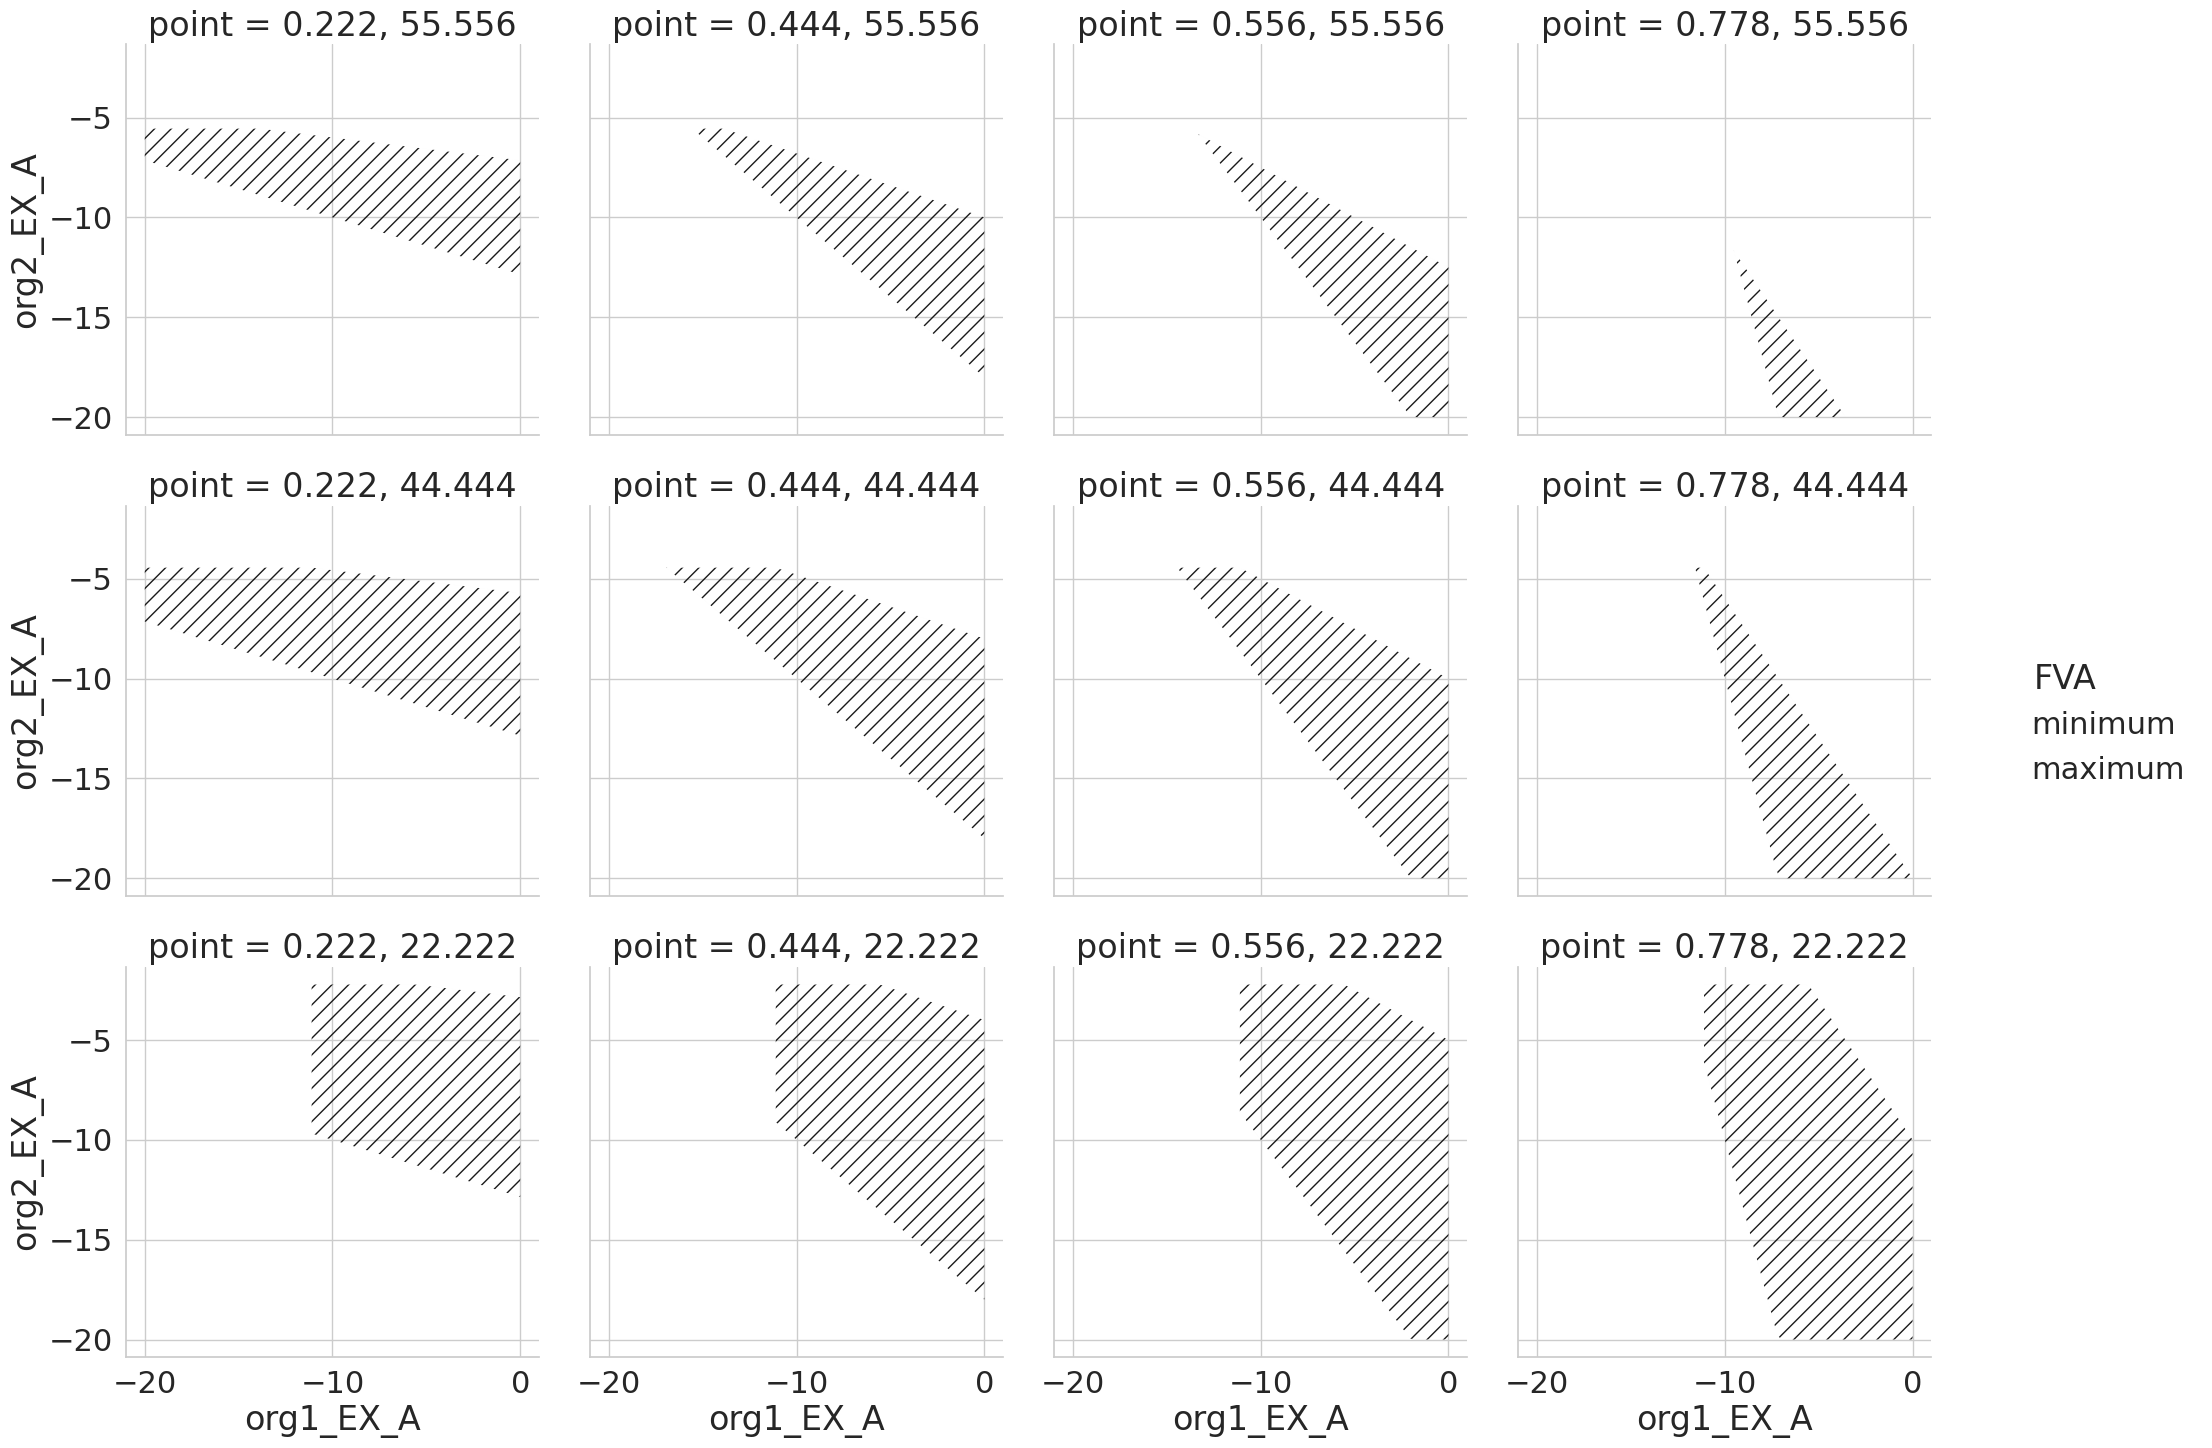

In [ ]:
toy_model.plot.plot_qFCA()